In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


import numpy as np

import matplotlib
import matplotlib.pyplot as plt
#e the second transition coupled to a cavity
from numpy.random import choice as chose
rng = np.random.RandomState(23455)

import time
import warnings
warnings.filterwarnings('error')

"""
Dependencies:
--------------

Tensorflow 2.6.0
Numpy 1.21.2
Qutip 4.6.2
Matplotlib 3.4.2
""";

In [14]:
class RL_LSTM:
    """
    A class for Initializing and training the Agent. Implements a continuous variation of the REINFORCE algorithm
    utilizing gaussian policies. Use of LSTM layer in the agent network allows the removal of state observation
    at each timestep.
    
    Params:
    -------
    batchsize: (int) Number of samples in each batch used in the batch gradient descent updates.
    n_actions: (int) Number of distinct actions that the agent can control.
    n_steps: (int) Number of discrete timesteps into which we divide the total episode time.
    sigma: (float) Determines width of the probability distribution from which each action is sampled.
    num_epochs: (int) Number of training-update cycles to carry out. (If training to convergence, set this to a
                      high value and include a termination condition within training loop.)

    """
    
    def __init__(self, batchsize=64, n_actions=2, n_steps=10, sigma=0.1, num_epochs=300):
        
        self.batchsize=batchsize
        self.n_actions = n_actions
        self.n_steps = n_steps
        self.sigma=sigma
        # initialize the states to be passed to the NN. simply a list where each entry highlights the current
        # timestep. This is the only required form of 'state' input to the agent.
        self.states=np.zeros([self.batchsize, self.n_steps,1])
        self.states[:,:,0]=np.broadcast_to(np.arange(self.n_steps), (self.batchsize, self.n_steps))/self.n_steps 
        # Define an array to store the average reward acheived for each "epoch".
        self.avg_reward=np.zeros(num_epochs)
        self.num_epochs=num_epochs
        # epoch_counter.
        self.epoch=0


    def init_net(self, LSTM_units=50, dense_units=30, learning_rate=0.005):
        """
        Initializes a NN with INPUT-LSTM-DENSE-OUTPUT structure. By default tanh activations for dense layers.
        Compiled with MSE loss and Adaptive gradient descent optimizer.
        Params:
        -------
        LSTM_units: (int) Number of Neurons in the LSTM layer.
        dense_units: (int) Number of Neurons in the dense layer.
        learning_rate: (int) Learning rate for the optimizer.
        """
        self.net = Sequential()
        self.net.add(LSTM(LSTM_units, batch_input_shape=(None, self.n_steps, 1), return_sequences=True))
        self.net.add(Dense(dense_units, activation='tanh'))
        self.net.add(Dense(self.n_actions, activation='tanh'))
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate)
        self.net.compile(loss='mean_squared_error', optimizer=optimizer) #'adam', metrics=['accuracy'] optimizers.SGD(lr=0.001) 'adadelta'
        
    def get_actions(self):
        """
        Generates all agent actions for an entire batch. No input required since all 'observations' are the same
        and defined as an attribute for the class. Also, seeing as we need not observe the state, all actions
        can be determined at the start then implemented all in one go, more like a black box optimization 
        technique than the standard MDP model of RL. This is simply a quirk of the non-observability of the process
        and how the LSTM layers in tf.keras are implemented.
        """
        # obtain a tensor of mean values of structure [batch, step, control] by consulting the agent.
        means=self.net.predict(self.states[:,:,:])[:,:,:]
        # Add noise based on a normal distribution of sttdev sigma to mimick sampling from a Gaussian policy
        # with the same parameters
        noise = tf.random.normal(shape=means.shape,mean=0.0, stddev=self.sigma, dtype=means.dtype)
        actions = means+noise
        return actions
   


    def do_epoch(self, step):
        """
        Single cycle of training/update loop.
        Param:
        ------
        step: (func) A function (Defined outside the class) that takes and processes the agent action/s, 
                        implements the desired system dynamics and returns the numerical reward signal.
        """
        # Array to keep track of the reward for each sample in the batch
        FinalReward=np.zeros(self.batchsize)
        # Get actions to be carried out
        actions=self.get_actions()
        for batch in range(self.batchsize):
            # This can potentially be parallelised.
            reward = step(actions[batch,:,:])
            FinalReward[batch]=reward
        best_index = np.argmax(FinalReward)
        self.current_best_reward = FinalReward[best_index]
        self.current_best_action = actions[best_index,:,:]
        # trains the network on the current batch. Essentially this is a "trick" that allows us to implement
        # the reinforce update and change action probabilities based on their respective episode rewards without
        # the need to define custom loss functions via the tensorflow backend.
        self.net.train_on_batch(self.states, actions, sample_weight=(FinalReward[:]-FinalReward[:].mean())) #Train (if yoy don't want the baseline in the REINFORCE algorithm just remove -FinalReward[:].mean())
        # record average reward for this training cycle
        self.avg_reward[self.epoch]=FinalReward[:].sum()/self.batchsize
        self.epoch+=1
        return
    
    def lc_plot(self):
        """
        Plot Learning curve
        """
        plt.plot(self.avg_reward)
        plt.xlabel(r"$epoch$", fontsize=20)
        plt.ylabel(r"$<Reward>_{batch}$", fontsize=20)
        

In [15]:
# Two simple three level environments

import qutip as qt
class SimpleSTIRAPenv:
    """
    A simple environment to implement 3 level dynamics while controlling the respective rabi frequencies.
    """
    def __init__(self, n_steps=10, T=1., resolution=10, omega_0=75., gamma=1., sharpness=6):
        self.rho0=qt.fock_dm(4,0)
        self.n_steps = n_steps
        self.T=T
        self.resolution=resolution
        self.Omega_0 = omega_0
        self.gamma = 1.
        self.H_p = 0.5 * (qt.projection(4,1,0) + qt.projection(4,0,1))
        self.H_s = 0.5 * (qt.projection(4,2,1) + qt.projection(4,1,2))

        self.time=np.linspace(0.,self.T, resolution*n_steps)
        self.timeplot = np.array([n*((1/resolution*n_steps)*omega_0)/np.pi for n in range(resolution*n_steps)])
        self.delta=0.0*omega_0
        self.Delta=0.0*omega_0
        #delta=Omega_0*0.15
        #Delta=-23.5*delta #uncomment if you want to introduce a bias
        self.H_d = self.Delta * qt.projection(4,1,1) + self.delta * qt.projection(4,2,2)
        #Artificial environment Lindblad operator:
        self.L = np.sqrt(self.gamma) * qt.projection(4,3,1)
        # A paramenter that determines the shape of the tanh curve joining two consecutive action values
        self.sharpness=sharpness
    
    def tanh(self, offset, gap):
        ts=np.linspace(-1,1,self.resolution)
        return ((gap/2) * (np.tanh(ts*self.sharpness)+1)) + offset

    def get_pulses_from_pwc(self, pwc):
        full_pulse = np.zeros_like(self.time)
        full_pulse[:int(self.resolution/2)]=[pwc[0]]*int(self.resolution/2)
        for i in range(0,(self.n_steps-1)):
            gap = pwc[i+1]-pwc[i]
            full_pulse[(i*self.resolution) + int(self.resolution/2) : ((i+1)*self.resolution) + int(self.resolution/2)] = self.tanh(offset=pwc[i],gap=gap)[:]
        full_pulse[-int(self.resolution/2):]=[pwc[-1]]*int(self.resolution/2)
        return full_pulse
    
    def get_controls(self, single_action):
        # here single action will be a tensor 'slice' of the full action tensor at a particular batch_index
        # of the form [step_num, control]
        pump = self.get_pulses_from_pwc(single_action.numpy()[:,0]*self.Omega_0)
        stokes = self.get_pulses_from_pwc(single_action.numpy()[:,1]*self.Omega_0)
        return pump, stokes
        
    def step(self, single_action_sample, collapse=True):
        Omega_P, Omega_S = self.get_controls(single_action=single_action_sample)
        c_ops = []
        if collapse==True:
            c_ops.append(self.L)
        result=qt.mesolve([self.H_d, [self.H_p, Omega_P], [self.H_s, Omega_S]], 
                          rho0=self.rho0, tlist=self.time, c_ops=self.L)
        reward = result.states[-1][2,2].real
        self.info = {"State History": result.states[:]}
        
        return reward
    
    def plot(self,best_action_sample):
        pump, stokes = self.get_controls(best_action_sample)
        plt.figure(1, figsize=(9,6))
        plt.plot(self.timeplot, pump, label=r"$\Omega_P$")
        plt.plot(self.timeplot, stokes, label=r"$\Omega_S$")
        plt.legend(fontsize=18)
        populations = np.zeros((self.time.shape[0], 4))
        _, info = self.step(best_action_sample, collapse=False)
        for i, t in enumerate(self.time):
            state = info["State History"][i]
            populations[i,:] = np.abs(state.diag()[:])**2
        plt.figure(2, figsize=(9,6))
        for i in range(4):
            plt.plot(self.timeplot, populations[:,i], label="|{}>".format(i))
        plt.legend()
        
        
class DetuningEnv:
    """
    Environement to implement the 3 level dynamics with control over both rabi frequencies and detunings.
    Using reasonable experimental params. Three level systems with sink state coulped to excited state of 
    form |g e f>|sink>.
    Params:
    -------
    n_steps: (int) Number of discrete timesteps over which we divide the full evolution time. MUST MATCH 
                        RL_LSTM attribute.
    T: (float) Maximum time for the system dynamics.
    gamma: (float) Rate for the artificial lindblad operator.
    resolution: (int) MUST BE EVEN. Number of points within each discrete step to 'monitor'. 
                        Higher reslution will generally be slower but will lead to "smoother" 
                            more accurate results.
    sharpness: (float) Determines the shape of the pulses. High value--> step like pulses; 
                        Lower Value--> sawtooth like pulses.
    """
    def __init__(self, n_steps=15, T=1., gamma=1., resolution=10, sharpness=2):
        # initial state |100>|0>
        self.rho0=qt.fock_dm(4,0)
        # Must be same n_steps as RL_LSTM class
        self.n_steps = n_steps
        # Time in microseconds
        self.T=T
        self.resolution=resolution
        # Coupling strengths etc... in MHz
        self.Omega_0 = (2 * np.pi) * 8
        self.max_delta_p = (2 * np.pi) * 10
        self.max_delta_2 = (2*np.pi) * 0.000001
        self.gamma = (2*np.pi)*3
        # Define useful operators for building hamiltonian
        self.H_p = 0.5 * (qt.projection(4,1,0) + qt.projection(4,0,1))
        self.H_s = 0.5 * (qt.projection(4,2,1) + qt.projection(4,1,2))
        self.H_dp = qt.projection(4,1,1)
        self.H_d2 = qt.projection(4,2,2)
        # Define times to pass to qt.mesolve
        self.time=np.linspace(0.,self.T, resolution*n_steps)
        self.timeplot = self.time
        #Artificial environment Lindblad operator to implement loss mechanism via sink state
        self.L = np.sqrt(self.gamma) * qt.projection(4,3,1)
        # A paramenter that determines the shape of the tanh curve joining two consecutive action values
        self.sharpness=sharpness
    
    def tanh(self, offset, gap):
        # builds a Tanh function to join two distinct points on the pulses. Gives us control over how "smooth"
        # the pulses are. (NB. This can only be done in this case and generally not in the tradition RL context)
        ts=np.linspace(-1,1,self.resolution)
        return ((gap/2) * (np.tanh(ts*self.sharpness)+1)) + offset

    def get_pulses_from_pwc(self, pwc):
        # Get the full pulses from the list of action values postulated by the agent.
        full_pulse = np.zeros_like(self.time)
        full_pulse[:int(self.resolution/2)]=[pwc[0]]*int(self.resolution/2)
        for i in range(0,(self.n_steps-1)):
            gap = pwc[i+1]-pwc[i]
            full_pulse[(i*self.resolution) + int(self.resolution/2) : ((i+1)*self.resolution) + int(self.resolution/2)] = self.tanh(offset=pwc[i],gap=gap)[:]
        full_pulse[-int(self.resolution/2):]=[pwc[-1]]*int(self.resolution/2)
        return full_pulse
    
    def get_controls(self, single_action):
        # here single action will be a tensor 'slice' of the full action tensor at a particular batch_index
        # of the form [step_num, control]
        delta_p = self.get_pulses_from_pwc(single_action.numpy()[:,0] * self.max_delta_p)
        delta_2 = self.get_pulses_from_pwc(single_action.numpy()[:,1] * self.max_delta_2)
        omega_p = self.get_pulses_from_pwc((single_action.numpy()[:,2] + 1)/2 * self.Omega_0)
        omega_s = self.get_pulses_from_pwc((single_action.numpy()[:,3] + 1)/2 * self.Omega_0)
        return delta_p, delta_2, omega_p, omega_s
        
    def step(self, single_action_sample, collapse=True):
        # Carries out a full episode of system dynamics for a single action sample within a batch
        delta_p, delta_2, omega_p, omega_s = self.get_controls(single_action=single_action_sample)
        c_ops = []
        if collapse==True:
            c_ops.append(self.L)
        result=qt.mesolve([[self.H_p, omega_p], [self.H_s, omega_s], [self.H_dp, delta_p], [self.H_d2, delta_2]], 
                          rho0=self.rho0, tlist=self.time, c_ops=self.L)
        reward = result.states[-1][2,2].real
        self.info = {"State History": result.states[:]}
        
        return reward
    
    def plot(self,best_action_sample, collapse=True):
        # Plotting function
        delta_p, delta_2, omega_p, omega_s = self.get_controls(best_action_sample)
        plt.figure(1, figsize=(9,6))
        plt.plot(self.timeplot, delta_p/(2*np.pi), label=r"$\delta_P$")
        plt.plot(self.timeplot, delta_2/(2*np.pi), label=r"$\Delta$")
        plt.plot(self.timeplot, omega_p/(2*np.pi), label=r"$\Omega_P$")
        plt.plot(self.timeplot, omega_s/(2*np.pi), label=r"$\Omega_S$")
        plt.xlabel("(ns)", fontsize=16)
        plt.ylabel(r"2 $\pi$ MHz", fontsize=16)
        plt.legend(fontsize=18)
        populations = np.zeros((self.time.shape[0], 4))
        reward = self.step(best_action_sample, collapse=collapse)
        for i, t in enumerate(self.time):
            state = self.info["State History"][i]
            populations[i,:] = np.abs(state.diag()[:])**2
        plt.figure(2, figsize=(9,6))
        for i in range(3):
            plt.plot(self.timeplot, populations[:,i], label="|{}>".format(i))
        plt.plot(self.timeplot, populations[:,-1], label="|SINK>".format(i))
        plt.legend()
        plt.xlabel("(ns)", fontsize=16)
        plt.ylabel("Populations", fontsize=16)

In [16]:
# Instatiate both classes
lstm = RL_LSTM(n_actions=4, num_epochs=100, n_steps=30)
stirap= DetuningEnv(n_steps=lstm.n_steps)
# initialize network
lstm.init_net()
global_best_reward = 0.
# run training loop for num_epochs
for epoch in range(lstm.num_epochs):
    lstm.do_epoch(stirap.step)
    if lstm.current_best_reward>global_best_reward:
        global_best_reward=lstm.current_best_reward
        global_best_action=lstm.current_best_action
    print("\r Epoch ", epoch, " --- average reward ", lstm.avg_reward[epoch],end="\r")
    


KeyboardInterrupt: 

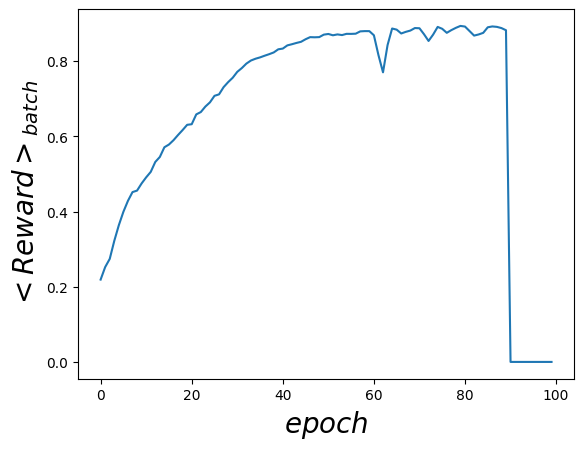

In [17]:
#Learning curve
lstm.lc_plot()

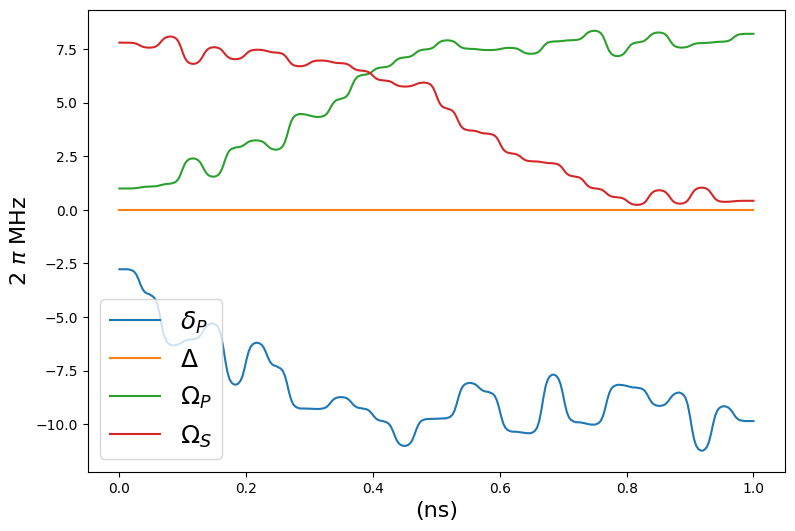

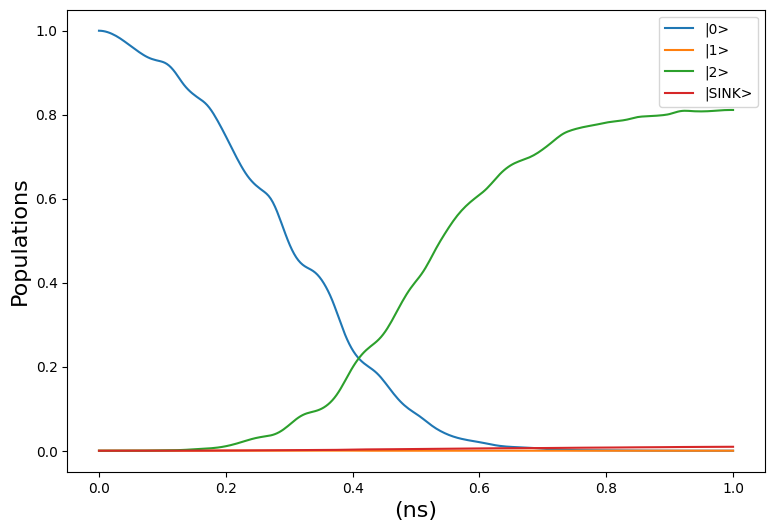

In [19]:
#Find the optimal signal once the model is trained. Apply the trained agent over one batch and record each action
# sample. Then use asses each action using the step function and chose the actions tht acheive the highest reward
# as our candidate for the optimal control strategy. There are several different ways you could do this,
# the simplest being simply removing the "width" of the gaussian policy and applying the agent deterministically.
stirap= DetuningEnv(n_steps=lstm.n_steps)
actions = lstm.get_actions()
FinalReward=np.zeros(actions.shape[0])
for batch in range(actions.shape[0]):
    reward =stirap.step(actions[batch,:,:], collapse=False)
    FinalReward[batch]=reward
b=np.argmax(FinalReward)
stirap.plot(actions[b,:,:], collapse=False)